## CS585: Natural Language Processing
### Language Models
<br><br>
#### Illinois Institute of Technology  
#### Aron Culotta

<br><br><br><br><br>

## Last week

- Dynamic programming solutions to parsing.
- Uses a fixed set of rules (context-free grammar) to determine if a sentence was valid or not.
- Because of ambiguity, each sentence has multiple possible parses.

## This week
- How do we score one sentence as more likely than another?
- Will use some probability:
  - $P($"I'm sorry Dave"$) > P($ "Sorry Dave I'm" $)$

<br><br><br>

## Motivation

- Why is it important to be able to score the probability of sentences?

Example: **Predictive text**

![figs/predict.png](figs/predict.png)

![figs/unicorn.jpg](figs/unicorn.jpg)

![figs/now.jpg](figs/now.jpg)

Many other applications:

- Machine translation

![tranl](figs/tranl.png)

> $P($ "he briefed reporters on the main contents of the statement" $) $ $ > $  
> $P($ "he briefed to reporters the main contents of the statement" $)$

- Speech recognition 

> $P($ "I am hungry" $) $ $ > P($ "Eye am hungry" $)$


#### More generally:
- Due to the prevalence of ambiguity, we need a way to rank probable interpretations of a sentence
- In the future, we'll look at probability of parses
- Today, we'll start with a simpler task
  - The probability of a sentence (word sequence).

## Probability of a sentence

$p(w_1 \ldots w_m)=$?

E.g., $p($"Sam I am.$")=?$


Given a large sample of sentences $D$, how can we estimate the probability of one particular sentence?

<br><br>
**Analogy**: Given a sample of $n$ people, how do we estimate $p($ brown eyes $)$?

<br><br>
$p($ brown eyes $)= \#($brown eyes$) $ $ / $ $n$  
= "the fraction of all people that have brown eyes"


<br>
So, returning to the above, 

$p($"Sam I am.$")=$ the fraction of all sentences that equal "Sam I am."

#### Why is this a bad idea?

<br><br><br><br>
Most sentences occur only once.  
$p(w_1 \ldots w_m) \approx \frac{1}{n}$

Any sentence not in $D$ will have probability 0.

Instead, to make estimating these probabilities possible, we need to make assumptions. E.g.,

#### Independence assumption

Recall from probability: if $A$ and $B$ are independent events, then $P(A,B) = P(A) * P(B)$
- E.g., P("It will rain tomorrow in Chicago" AND " My knee hurts today") =  
P("It will rain tomorrow in Chicago") * P("My knee hurts today")

If we assume that each word in a sentence is an independent event then:

$p(w_1 \ldots w_m) \approx p(w_1) * p(w_2) * \ldots p(w_m)$

(Decompose the joint probability of the words in a sentence into the product of individual word probabilities.)



This is a bad assumption: **why?**
<br><br><br><br>
- "San Francisco", "love you", ...

- we will return to this problem later today

But first: how do we estimate the probability of a single word $p(w_i)$ given a dataset $D$?
<br><br><br><br>

## Estimating unigram probabilities

**unigram:** a single word; or, a phrase of length 1.

To estimate unigram probability from some dataset of text, just count the word frequency:

$$ p(w_i) = \frac{C(w_i)}{T} $$

- $C(w_i)=$ number of times word $w_i$ appears in data
- $T=$ number of tokens in data

Recall definition of probability:
- $0 \le p(w_i) \le 1$ $ \forall i$
- $\sum_i p(w_i) = 1$

This is an example of a **<font color="blue">multinomial distribution</font>**:
- A distribution over $n$ discrete events
- In each trial, only one event can occur.
- E.g., roll of an $n$-sided die.
- Imagine a giant die with a word on each face. Each word is weighted by its probability. We can sample words by rolling the die.

<br>

```
<s> I am Sam </s>  
<s> Sam I am </s>  
<s> I do not like green eggs and ham </s>
```

- $p($I$)$ $ = \frac{3}{20} = 0.15$
- $p($Sam$)$ $ = \frac{2}{20} = 0.1$
- ...

In [1]:
# Counter: an enhanced dict for counting
# https://docs.python.org/3.6/library/collections.html#collections.Counter
from collections import Counter

d = Counter()
d.update(['a', 'b', 'c'])
d.update(['a', 'a', 'b'])
d

Counter({'a': 3, 'b': 2, 'c': 1})

In [2]:
# Example of estimating unigram probabilities from a set of documents.

docs = ['<s> I am Sam </s>',
        '<s> Sam I am </s>',
        '<s> I do not like green eggs and ham </s>']

def estimate_unigram_probs(docs):
    """
    Compute p(w), the probability of each unigram in this data.
    p(w) = count(w) / total_num_tokens
    """
    counts = Counter()
    for doc in docs:
        tokens = doc.split()   # split sentence into words using spaces
        counts.update(tokens)  # increments counts for all items in tokens
    print('counts=', counts)   # for debugging
    # Normalize so probabilities sum to 1.
    total_tokens = sum(counts.values())
    return {token: value / total_tokens for token, value in counts.items()}
    
unigram_probs = estimate_unigram_probs(docs)
# print in descending order.
sorted(unigram_probs.items(), key=lambda x: x[1], reverse=True)

counts= Counter({'<s>': 3, 'I': 3, '</s>': 3, 'am': 2, 'Sam': 2, 'do': 1, 'not': 1, 'like': 1, 'green': 1, 'eggs': 1, 'and': 1, 'ham': 1})


[('<s>', 0.15),
 ('I', 0.15),
 ('</s>', 0.15),
 ('am', 0.1),
 ('Sam', 0.1),
 ('do', 0.05),
 ('not', 0.05),
 ('like', 0.05),
 ('green', 0.05),
 ('eggs', 0.05),
 ('and', 0.05),
 ('ham', 0.05)]

## Probability of a sentence using unigram probabilities

Once we've estimated unigram probabilities, we can now compute the probability of a new sentence with $m$ words by the product of its unigram probabilities.

$p(w_1 \ldots w_m) \approx p(w_1) * p(w_2) * \ldots p(w_m)$

(True because of our earlier independence assumption.)

In [3]:
def sentence_probability(unigrams, sentence):
    proba = 1
    for word in sentence:
        proba *= unigrams[word]
    return proba

sentence_probability(unigram_probs, ['Sam', 'am', 'I'])

0.0015000000000000002

In [4]:
sentence_probability(unigram_probs, ['Sam', 'I', 'I'])

0.00225

#### What happens for very long sentences?

In [5]:
# The sentence with 1000 Sams
sentence_probability(unigram_probs, ['Sam'] * 1000)

0.0

<br><br><br><br>

### To avoid underflow, we use log probabilities.

$$p(w_1 \ldots w_m) = p(w_1) * p(w_2) * \ldots p(w_m) = \prod_{i=1}^m p(w_i)$$

$$\log p(w_1 \ldots w_m) = \log \left(p(w_1) * p(w_2) * \ldots p(w_m)\right) = \sum_{i=1}^m \log p(w_i)$$

Product of probabilities become sum of log probabilities.



In [6]:
import math
def sentence_log_probability(unigrams, sentence):
    proba = 0
    for word in sentence:
        proba += math.log10(unigrams[word])
    return proba

sentence_log_probability(unigram_probs, ['Sam', 'am', 'I'])

-2.8239087409443187

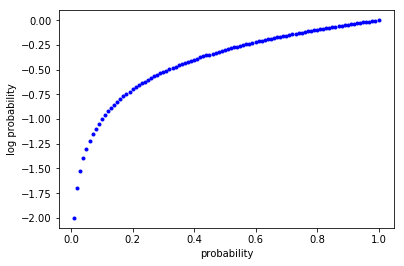

In [7]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
probas = (np.arange(100)+1)/100
plt.figure()
plt.plot(probas, np.log10(probas), 'b.')
plt.xlabel('probability')
plt.ylabel('log probability')
plt.show()

In [8]:
# So, small probabilities result in large negative numbers

## Poverty of unigrams

$p(w_1 \ldots w_m) \approx p(w_1) * p(w_2) * \ldots p(w_m)$


Why is this a bad assumption?

<br><br><br>
Ignores all structure of language


In [9]:
## e.g., cannot tell that the first sentence is more likely than the second.
sentence_log_probability(unigram_probs, ['Sam', 'I', 'am']) == sentence_log_probability(unigram_probs, ['Sam', 'Sam', 'I'])

True

Really, we'd like a rich syntactic/semantic representation with probabilities assigned.  


We'll get to more complex representations in the future, but for now, we can do better by at least modeling **n-grams**, instead of just unigrams.

What is the probability of the $i$th word in a sentence, given all the previous words?
$$ p(w_i  | w_1 w_2 \ldots w_{i-1})?$$ 

We will make an assumption that the $i$th word depends only on the previous $n$ words (**Markov** assumption):

$$ p(w_i | w_1 w_2 \ldots w_{i-1}) \approx p(w_i | w_{i-1} w_{i-2} \ldots w_{i-n}) $$

e.g., 4-grams:

$p($ "flu" $ | $ "He is sick with the" $ ) $ $\approx p($"flu"$ | $ "sick with the" $)$

$$ p(w_i | w_{i-1} w_{i-2} \ldots w_{i-n}) = \frac{C(w_{i-n}, \ldots, w_{i-2} w_{i-1} w_i)}{C(w_{i-n} \ldots w_{i-2} w_{i-1})} $$

<br>
Can estimate from data. E.g., search engines:

= Num hits for ["sick with the flu"](https://www.google.com/search?q=%22i+am+sick+with+the+flu%22) / Num hits for ["sick with the"](https://www.google.com/search?q=%22i+am+sick+with+the%22)  
$ \approx 18,600 / 82,500 \approx 0.23$ 

<br><br>
See also [Google's NGram corpus](https://books.google.com/ngrams/graph?content=sick+with+the+flu+%2F+sick+with+the&year_start=1800&year_end=2000&corpus=15&smoothing=3&share=&direct_url=t1%3B%2C%28sick%20with%20the%20flu%20/%20sick%20with%20the%29%3B%2Cc0)
- Ngram statistics extracted from millions of books.


<br><br>
Let's start with a simpler example:


```
<s> I am Sam </s>  
<s> Sam I am </s>  
<s> I do not like green eggs and ham <s>
```

In [10]:
def iter_ngrams(doc, n):
    """Return a generator over ngrams of a document.
    Params:
      doc...list of tokens
      n.....size of ngrams"""
    return (doc[i : i+n] for i in range(len(doc)-n+1))
    
[ngram for ngram in 
 iter_ngrams(['<s>', 'hi', 'there', 'how', 'are', 'you', '</s>'], 3)]

[['<s>', 'hi', 'there'],
 ['hi', 'there', 'how'],
 ['there', 'how', 'are'],
 ['how', 'are', 'you'],
 ['are', 'you', '</s>']]

**Implementation idea**: store ngram counts as a dict where
- key is an ngram (a tuple of strings)
- value is a Counter object of word counts

```python
{('I', 'am'): {'Sam': 2, 'Adam': 1},
 ('Sam', 'I'): {'am': 4, 'will': 1}
}
```
e.g., 
- "I am Sam" occurs twice; "I am Adam" occurs once
- "Sam I am" occurs 4 times; "Sam I will" occurs once

We will then normalize each of the Counters:


```python
{('I', 'am'): {'Sam': 2/3, 'Adam': 1/3},
 ('Sam', 'I'): {'am': 4/5, 'will': 1/5}
}
```
Thus, we have $k$ multinomial distributions, where $k$ is the number of unique keys (ngrams)  
$ p(w_i | w_{i-1} w_{i-2} \ldots w_{i-n}) $ for $i=1 $ to $ k$


In [11]:
mydict = {['a','b','c']: 10}  # list cannot be key of a dict. Why??

TypeError: unhashable type: 'list'

In [12]:
mydict = {('a','b','c'): 10}    # tuples can be key of a dict. Why??
mydict[('a', 'b', 'c')]

10

In [13]:
from collections import defaultdict
# dict with default values:
mydict = defaultdict(lambda: 100)
mydict['a'] = 10
print(mydict['a'])
print(mydict['b'])

10
100


In [14]:
sorted([('a', 1), ('b', 2)], key=lambda x: -x[1])

[('b', 2), ('a', 1)]

In [15]:
def estimate_ngram_probs(docs, n, verbose=True):
    """Compute p(w_i|w_i-1, w_i-2, ..., w_i-n), the probability of each ngram in this data.
    = count(w_i-1, w_i-2, ..., w_i-n, w_i) / count(w_i-1, w_i-2, ..., w_i-n)
    
    Params:
      docs...list of strings
      n......ngram size"""
    # Count 
    counts = defaultdict(lambda: Counter())
    for doc in docs:
        for ngram in iter_ngrams(doc.split(), n):
            counts[tuple(ngram[:-1])].update([ngram[-1]])

    if verbose:
        print('counts=\n', '\n'.join(str(i) for i in counts.items()))   # for debugging
    
    # Normalize probabilities to sum to 1.0
    for ngram, word_counts in counts.items():
        total = sum(word_counts.values())
        counts[ngram] = {word: count / total for word, count in word_counts.items()}
    return counts

sam_ngrams = estimate_ngram_probs(docs, 3)
sam_ngrams

counts=
 (('<s>', 'I'), Counter({'am': 1, 'do': 1}))
(('I', 'am'), Counter({'Sam': 1, '</s>': 1}))
(('am', 'Sam'), Counter({'</s>': 1}))
(('<s>', 'Sam'), Counter({'I': 1}))
(('Sam', 'I'), Counter({'am': 1}))
(('I', 'do'), Counter({'not': 1}))
(('do', 'not'), Counter({'like': 1}))
(('not', 'like'), Counter({'green': 1}))
(('like', 'green'), Counter({'eggs': 1}))
(('green', 'eggs'), Counter({'and': 1}))
(('eggs', 'and'), Counter({'ham': 1}))
(('and', 'ham'), Counter({'</s>': 1}))


defaultdict(<function __main__.estimate_ngram_probs.<locals>.<lambda>>,
            {('<s>', 'I'): {'am': 0.5, 'do': 0.5},
             ('<s>', 'Sam'): {'I': 1.0},
             ('I', 'am'): {'</s>': 0.5, 'Sam': 0.5},
             ('I', 'do'): {'not': 1.0},
             ('Sam', 'I'): {'am': 1.0},
             ('am', 'Sam'): {'</s>': 1.0},
             ('and', 'ham'): {'</s>': 1.0},
             ('do', 'not'): {'like': 1.0},
             ('eggs', 'and'): {'ham': 1.0},
             ('green', 'eggs'): {'and': 1.0},
             ('like', 'green'): {'eggs': 1.0},
             ('not', 'like'): {'green': 1.0}})

In [16]:
# Pr(Sam | "I am")
sam_ngrams[('I', 'am')]['Sam']

0.5

As before, we can compute the probability of a sentence by multiplying probabilities of all ngrams in the sentence.

$$p(w_1 \ldots w_m) = p(w_n|w_{n-1} \ldots w_1) * p(w_{n+1}|w_{n} \ldots w_2) * \ldots * p(w_m|w_{m-1}\ldots w_{m-n})$$

e.g. for $n=2$

$p($ &langle;s&rangle; Sam I am &langle;/s&rangle;$) = p($ Sam $\mid $ &langle;s&rangle; $) * p($I $ \mid $ Sam $) * p($ am $ \mid $ I $) *  p($ &langle;/s&rangle; $ \mid $ am $ ) $

And equivalently in log space:

$$\log p(w_1 \ldots w_m) = \log p(w_n|w_{n-1} \ldots w_1) + \log p(w_{n+1}|w_{n} \ldots w_2) + \ldots + \log p(w_m|w_{m-1} \ldots w_{m-n})$$



In [17]:
[x for x in iter_ngrams(['<s>', 'Sam', 'I', 'am', '<s>'], 3)]

[['<s>', 'Sam', 'I'], ['Sam', 'I', 'am'], ['I', 'am', '<s>']]

In [18]:
def sentence_log_probability_ngrams(ngrams, sentence, n):
    proba = 0
    # loop through all ngrams
    for ngram in iter_ngrams(sentence, n):
        # e.g., ngram = ['Sam', 'I', 'am']
        #      prefix = ['Sam', 'I']
        #        word = 'am'f
        prefix = ngram[:-1]
        word = ngram[-1]
        # P(wi | ngram)
        this_prob = math.log10(ngrams[tuple(prefix)][word])
        print('Pr(%s|%s)=%g' % (word, prefix, this_prob))
        proba += this_prob              
    return proba

sentence_log_probability_ngrams(sam_ngrams, ['<s>', 'Sam', 'I', 'am', '</s>'], 3)

Pr(I|['<s>', 'Sam'])=0
Pr(am|['Sam', 'I'])=0
Pr(</s>|['I', 'am'])=-0.30103


-0.3010299956639812

<br><br><br>
A "modern" example...

In [22]:
!head tweets.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
trump_tweets = open('tweets.txt').readlines()
print('read %d tweets from Donald J. Trump (@realDonaldTrump)' % len(trump_tweets))
print(trump_tweets[0])

read 3200 tweets from Donald J. Trump (@realDonaldTrump)
<s> busy week planned with a heavy focus on jobs and national security top executives coming in at 9 00 a m to talk manufacturing in america </s>



In [24]:
trump_ngrams = estimate_ngram_probs(trump_tweets, 3, verbose=False)

In [25]:
# What does Trump think about the media?
sorted(trump_ngrams[('media', 'is')].items(), key=lambda x: -x[1])

[('so', 0.11764705882352941),
 ('fake', 0.058823529411764705),
 ('covering', 0.058823529411764705),
 ('protecting', 0.058823529411764705),
 ('going', 0.058823529411764705),
 ('against', 0.058823529411764705),
 ('fawning', 0.058823529411764705),
 ('spending', 0.058823529411764705),
 ('trying', 0.058823529411764705),
 ('unrelenting', 0.058823529411764705),
 ('very', 0.058823529411764705),
 ('talking', 0.058823529411764705),
 ('on', 0.058823529411764705),
 ('really', 0.058823529411764705),
 ('totally', 0.058823529411764705),
 ('corrupt', 0.058823529411764705)]

In [26]:
# What does Trump think about the Hillary Clinton?
sorted(trump_ngrams[('clinton', 'is')].items(), key=lambda x: -x[1])

[('a', 0.10714285714285714),
 ('not', 0.10714285714285714),
 ('being', 0.07142857142857142),
 ('unfit', 0.07142857142857142),
 ('down', 0.03571428571428571),
 ('right', 0.03571428571428571),
 ('weak', 0.03571428571428571),
 ('out', 0.03571428571428571),
 ('the', 0.03571428571428571),
 ('taking', 0.03571428571428571),
 ('using', 0.03571428571428571),
 ('100', 0.03571428571428571),
 ('soft', 0.03571428571428571),
 ('bought', 0.03571428571428571),
 ('like', 0.03571428571428571),
 ('answering', 0.03571428571428571),
 ('guilty', 0.03571428571428571),
 ('trying', 0.03571428571428571),
 ('consulting', 0.03571428571428571),
 ('totally', 0.03571428571428571),
 ('spending', 0.03571428571428571),
 ('unqualified', 0.03571428571428571)]

## Sampling from ngram language models

Given probabilities $p(w_i | w_{i-1} w_{i-2} \ldots w_{i-n})$ $\forall i$, how can we sample sentences?


<br><br><br><br>
1. Sample an ngram $(w_1\ldots w_n)$ where $w_1 = $ &langle;s&rangle;
2. Sample an additional word from $p(w_i | w_{i-1} w_{i-2} \ldots w_{i-n})$
3. Loop until sample &langle;/s&rangle;

In [27]:
import random
# Sampling uniformly from a list.
random.sample(['a', 'b', 'c'], k=1)

['b']

In [28]:
import numpy as np
# Sampling from a multinomial distribution
np.random.choice(['a', 'b', 'c'], size=10, p=[.8, .15, .05])

array(['c', 'a', 'b', 'b', 'a', 'a', 'a', 'a', 'a', 'a'], 
      dtype='<U1')

In [29]:
# A simple TrumpBot
import random

def generate_sentences(ngrams, k):
    """Sample k sentences from given ngram model.
    Params:
      ngrams....ngram language model; a dict from ngram tuple to a dict
      k.........number of sentences to sample
    """
    # List of all ngrams that start with <s>
    start_ngrams = [ngram for ngram in ngrams if ngram[0] == '<s>']
    for i in range(k):  # sample k sentences.
        # sample uniformly from all start ngrams.
        ngram = random.sample(start_ngrams, 1)[0]
        sentence = []
        sentence.extend(ngram)
        while sentence[-1] != '</s>' and len(sentence) < 25:  # while not at end of sentence.
            # sample the next word
            sampled_word = np.random.choice(list(ngrams[ngram].keys()),      # words
                                            p=list(ngrams[ngram].values()),  # probabilities
                                            size=1)[0]
            sentence.append(sampled_word)
            # update most recent ngram
            ngram = tuple(list(ngram[-1:]) + [sampled_word])
        print(' '.join(sentence))
        
generate_sentences(trump_ngrams, 40)

<s> china steals united states </s>
<s> terrible attacks in turkey switzerland and germany and it was packed with great pros win </s>
<s> herb_stamper jackoffjosh711 senfrankniceley foxnews wsj we are with them sad </s>
<s> prayers and condolences to those observing rosh hashanah here in the middle class since obama took office in orange county because we are going
<s> had a mental breakdown while talking about law and order </s>
<s> mypresidentme here s my plan </s>
<s> an old picture with nancy and ronald reagan there is no challenge can match the heart and fight and spirit just returned from colorado
<s> crooked hillary clinton cannot even bring herself to say and write whatever they want to makeamericagreatagain </s>
<s> russia just said the affordable care act will soon be gone </s>
<s> tcloer11 realdonaldtrump great speech on twitter u give me a joke </s>
<s> distlerjoyce realdonaldtrump nytimes everyone continues to subvert the will of the pro hillary clinton s open borders that

Bot or Human? (Trump Turing Test)  
> mexico has lost so badly i will make america great again  
> rupert murdoch is a failed spy afraid of being sued  
> rupert murdoch is a small one pathetic  
> karlrove is a borderless world where working people have no doubt  
> democrats are in my life fakenews  
> bill clinton and the build up of russian nukes not good  
> of course there is nothing more than the very average scream


### A problem with our approach so far...

```python
sorted(trump_ngrams[('media', 'is')].items(), key=lambda x: -x[1])

[('so', 0.11764705882352941),
 ('fake', 0.058823529411764705),
 ('covering', 0.058823529411764705),
 ('protecting', 0.058823529411764705),
 ('going', 0.058823529411764705),
 ('against', 0.058823529411764705),
 ('fawning', 0.058823529411764705),
 ('spending', 0.058823529411764705),
 ('trying', 0.058823529411764705),
 ('unrelenting', 0.058823529411764705),
 ('very', 0.058823529411764705),
 ('talking', 0.058823529411764705),
 ('on', 0.058823529411764705),
 ('really', 0.058823529411764705),
 ('totally', 0.058823529411764705),
 ('corrupt', 0.058823529411764705)]
```

What is 
$P($ "terrible" $ | $ "media is" $)$?

<br><br><br>

In [35]:
trump_ngrams[('media', 'is')]['terrible']

KeyError: 'terrible'

#### The problem with zero

- Events that do not occur in the input data are assigned probability 0
- We are underestimating events that we have not seen
  - $P($" terrible" $ | $ "media is" $) > 0$
- We assign zero probability to sentences that contain any 0 probability event
  - $P($"the media is terrible"$) = 0$

In [36]:
sentence_log_probability_ngrams(trump_ngrams, ['<s>', 'the', 'media', 'is', 'terrible', '</s>'], 3)

Pr(media|['<s>', 'the'])=-1.18392
Pr(is|['the', 'media'])=-0.544068


KeyError: 'terrible'

## Smoothing

- Reserve some probability mass for event we have not seen.

- Let $V$ be the number of unique words in our vocabulary.

- Recall unigram estimates:

$$ p(w_i) = \frac{C(w_i)}{T} $$
  - $C(w_i)=$ number of times word $w_i$ appears in data
  - $T=$ number of tokens in data
  
#### Laplacian smoothing

- Add one to the numerator
- Add $V$ to denominator to ensure probabilities sum to 1.
- Equivalently: pretend we saw every word in the vocabulary one additional time each

$$ p(w_i) = \frac{C(w_i) + 1}{T + V} $$


#### Add-k smoothing
- More generally we can add a fraction to the numerator to control how much smoothing we want
- typically $0 < k \le 1$
- Equivalently: pretend we saw every word in the vocabulary $k$ additional times.

$$ p(w_i) = \frac{C(w_i) + k}{T + kV} $$


Similarly, we can smooth ngram estimates. E.g., bigrams:

$$ p(w_i | w_{i-1}) = \frac{C(w_{i-1}w_i) + k}{C(w_{i-1}) + kV}$$






In [37]:
def estimate_unigram_probs_add_k(docs, k):
    """
    Compute p(w), the add-k smoothed probability of each unigram in this data.
    p(w) = (count(w) + k) / (total_num_tokens + total_num_types * k)
    """
    counts = Counter()
    for doc in docs:
        tokens = doc.split()   # split sentence into words using spaces
        counts.update(tokens)  # increments counts for all items in tokens
    # Normalize so probabilities sum to 1.
    total_tokens = sum(counts.values())
    total_types = len(counts)
    denom = total_tokens + k * total_types
    return {token: (value + k) / denom for token, value in counts.items()}
    
addk_unigram_probs = estimate_unigram_probs_add_k(docs, 1)
# print in descending order.
sorted(addk_unigram_probs.items(), key=lambda x: x[1], reverse=True)

[('<s>', 0.125),
 ('I', 0.125),
 ('</s>', 0.125),
 ('am', 0.09375),
 ('Sam', 0.09375),
 ('do', 0.0625),
 ('not', 0.0625),
 ('like', 0.0625),
 ('green', 0.0625),
 ('eggs', 0.0625),
 ('and', 0.0625),
 ('ham', 0.0625)]

In [38]:
# compare to unsmoothed estimates
sorted(unigram_probs.items(), key=lambda x: x[1], reverse=True)

[('<s>', 0.15),
 ('I', 0.15),
 ('</s>', 0.15),
 ('am', 0.1),
 ('Sam', 0.1),
 ('do', 0.05),
 ('not', 0.05),
 ('like', 0.05),
 ('green', 0.05),
 ('eggs', 0.05),
 ('and', 0.05),
 ('ham', 0.05)]

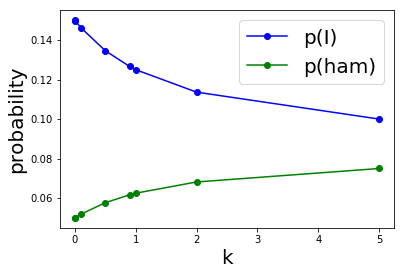

In [39]:
# How do probability estimates change as k increases?
plt.figure()
ks = [0, .01, .1, .5, .9, 1, 2, 5]
i_probs = []
ham_probs = []
for k in ks:
    probs = estimate_unigram_probs_add_k(docs, k)
    i_probs.append(probs['I'])
    ham_probs.append(probs['ham'])
plt.plot(ks, i_probs, 'bo-', label='p(I)')
plt.plot(ks, ham_probs, 'go-', label='p(ham)')
plt.xlabel('k', size=20)
plt.ylabel('probability', size=20)
plt.legend(loc='best', fontsize=20)
plt.show()

- We can see that the probabilities get more "smooth"; i.e., closer together.
- Smoothing "steals" probability mass from high probability events, and gives it to the low probability events

![figs/robin.jpg](figs/robin.jpg)


### Problems with add-k smoothing

Adjustments are often too large
  - rare events made too probable
  - common events made too improbable
  - For ngrams, wastes a lot of probability mass on nonsense ngrams
    - E.g., for trigrams:
    $$ p(w_i | w_{i-2} w_{i-1}) = \frac{C(w_{i-2}w_{i-3}w_i) + k}{C(w_{i-2}w_{i-1}) + kV}$$

    - Smoothing adds "simulated" counts for trigrams like "walk the the" and "I am do"
    
<br><br><br>

##  Interpolation

- As ngram size increases, we observe fewer examples to estimate the probabilities
- **Idea**: use a combination of smaller ngrams to estimate probabilities of larger ngrams

$$ \hat{P}(w_i|w_{i-2}w_{i-1}) = \lambda_1 P(w_i|w_{i-2}w_{i-1}) + \lambda_2 P(w_i|w_{i-1}) + \lambda_3 P(w_i)$$
- $\sum_i \lambda_i = 1$
- If trigram probability is 0, will still have nonzero probability for bigrams or unigrams
- Assumes we have a **closed vocabulary** (i.e., we know of all possible unigrams)

<br>
- $\lambda$s determine relative weight of trigrams/bigrams/unigrams
- Typically set with some held-out validation dataset.




- Many other smoothing approaches exist.
- In practice, smoothing most important for small datasets.
- If you have access to web-scale data, rare events can often be estimated well without much smoothing.

### Summary

- Given a sample of documents $D$, we can estimate probabilities of ngrams.
- The probability of a sentence is then the product of the probabilities of the ngrams it contains.
- Smoothing and interpolation are two ways of dealing with difficulties of estimating rare events from a finite sample.

#### image sources
- https://www.cs.colorado.edu/~martin/SLP/

In [36]:
from IPython.core.display import HTML
HTML(open('../custom.css').read())